In [18]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD
%matplotlib inline
import matplotlib.pyplot as plt
import DataPreprocessing_XW as spike_process



In [2]:
# Load desired data from 1 session 1 animal
# Note that there are 340 trials in 1 session
# (For more info https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)

data_path = '/Users/xinweichia/Documents/connected_lizards/Steinmetz_dataset/Richards_2017-10-31'

trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy') 
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
trial_feedback_time = np.load(data_path+'/'+'trials.feedback_times.npy')
trial_feedback_type = np.load(data_path+'/'+'trials.feedbackType.npy')
trial_response_time = np.load(data_path+'/'+'trials.response_times.npy')

visual_times = trials_visual_time
# Behaviour data

wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')


In [29]:
np.array([trials_visual_time[:10],trials_gocue_times[:10],trial_response_time[:10],trial_feedback_time[:10]])


array([[[ 62.80544741],
        [ 67.78158083],
        [ 71.3660981 ],
        [ 76.46615324],
        [ 79.53142229],
        [ 84.7664911 ],
        [ 89.71658205],
        [ 92.1890847 ],
        [ 94.44164958],
        [ 99.1568136 ]],

       [[ 63.44817205],
        [ 68.34945466],
        [ 71.94911534],
        [ 76.87319834],
        [ 80.29485601],
        [ 85.56054477],
        [ 90.31902497],
        [ 92.82906728],
        [ 94.86870166],
        [ 99.83998546]],

       [[ 64.95577101],
        [ 68.49708922],
        [ 72.08014241],
        [ 76.99658944],
        [ 81.79593827],
        [ 86.14660926],
        [ 90.63016031],
        [ 92.9631532 ],
        [ 95.02971311],
        [100.02935179]],

       [[ 64.98899802],
        [ 68.53305776],
        [ 72.11711817],
        [ 77.03440105],
        [ 81.82968188],
        [ 86.18375527],
        [ 90.66823086],
        [ 93.00027017],
        [ 95.06750501],
        [100.06558926]]])

In [80]:
trials_gocue_times,trial_feedback_time,trial_response_time


def sort_cells_trials(spike_time_binned, bin_size = 10):
    # Epoch duration is defined as the period after the visual stimulus

    # Sort into trials
    spike_time_binned_trial = np.empty(len(spike_time_cells), dtype=object)
    
    pre_stim_spike_time_binned_trial = np.empty(len(trials_intervals), dtype=object)
    post_stim_spike_time_binned_trial = np.empty(len(trials_intervals), dtype=object)
    post_go_cue_spike_time_binned_trial = np.empty(len(trials_intervals), dtype=object)
    post_feedback_post_stim_spike_time_binned_trial = np.empty(len(trials_intervals), dtype=object)
        
    for cell_num in np.arange(len(spike_time_cells)):
        
        spike_time_binned_trial[cell_num] = []
        
        pre_stim_spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        post_stim_spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        post_go_cue_spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        post_feedback_post_stim_spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        
        # Entire trial duration
        for i,trials_start_end in enumerate(trials_intervals):
            # Sort spikes into their trial numbers. 
            spike_time_binned_trial[cell_num].append(spike_time_binned[cell_num][int(np.floor(trials_start_end[0]*(1000/bin_size))) : int(np.floor(trials_start_end[1]*(1000/bin_size)))])

        # Pre-stim epoch (Visual Stim - 500ms : Visual Stim)
        for i,trials_start_end in enumerate(trials_intervals):
            pre_stim_spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_visual_time[i]*(1000/bin_size))-(500/bin_size))) : (int(np.floor(trials_visual_time[i]*(1000/bin_size))))]
            
        # Post-stim epoch (Visual Stim : Go Cue)
        for i,trials_start_end in enumerate(trials_intervals):
            post_stim_spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_visual_time[i]*(1000/bin_size)))) : (int(np.floor(trials_gocue_times[i]*(1000/bin_size))))]
        
        # Post-gocue epoch (Gocue : Reward) Very short duration
        for i,trials_start_end in enumerate(trials_intervals):
            post_go_cue_spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_gocue_times[i]*(1000/bin_size)))) : (int(np.floor(trial_feedback_time[i]*(1000/bin_size))))]
        
        # Post-reward epoch (Reward : Reward + 500ms)
        for i,trials_start_end in enumerate(trials_intervals):
            post_go_cue_spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trial_feedback_time[i]*(1000/bin_size)))) : (int(np.floor(trial_feedback_time[i]*(1000/bin_size))+(500/bin_size)))]
        
    # spike_time_binned_trial returns spikes that are sorted into cells and trials
    # spike_time_binned_trial_response returns spikes that are sorted into cells and trials, and spliced accordingly to desired epoch duration post-visual stim onset
        
        spike_time_binned_trial[cell_num]
        
    return spike_time_binned_trial, pre_stim_spike_time_binned_trial, post_stim_spike_time_binned_trial, post_go_cue_spike_time_binned_trial, post_go_cue_spike_time_binned_trial

# Shape of spike_time_binned_trial[cell_num][trial_num][# of bins]

#spike_time_binned_trial, spike_time_binned_trial_response = sort_cells_trials(spike_time_binned,40)
spike_time_binned_trial, pre_stim_spike_time_binned_trial, post_stim_spike_time_binned_trial, post_go_cue_spike_time_binned_trial, post_go_cue_spike_time_binned_trial = sort_cells_trials(spike_time_binned,10)

In [135]:
(np.reshape( (clusters_annotation >= 2),(-1) ) & np.reshape( (brain_regions == 'ORB'),(-1) )).shape

print(left_spike_time_response.shape)

len(np.unique(spike_clusters))


(522,)


778

In [19]:
dt = 1/100
dT = 2.5
T0 = .5

# Get neural activity data
good_cells, brain_regions ,br = spike_process.get_good_cells(data_path) # Get brain regions
spike_time_binned, spike_time_cells, cell_spikes_max = spike_process.bin_spikes(spike_times,10)
spike_time_binned_trial, spike_time_binned_trial_response = spike_process.sort_cells_trials(spike_time_binned,40,10)
left_spike_time_response, right_spike_time_response, no_response_spike_time_response = spike_process.sort_cells_trial_types(spike_time_binned_trial_response)

# Midbrain cells
regional_left_spike = spike_process.sort_cells_brain_regions(left_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_right_spike = spike_process.sort_cells_brain_regions(right_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_no_response_spike = spike_process.sort_cells_brain_regions(no_response_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
midbrain_concat_left_spike_times = spike_process.concat_trials_2_timeseries(regional_left_spike)
midbrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(regional_right_spike)
midbrain_concat_no_response_spike_times = spike_process.concat_trials_2_timeseries(regional_no_response_spike)

# Forebrain cells
regional_left_spike = spike_process.sort_cells_brain_regions(left_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
regional_right_spike = spike_process.sort_cells_brain_regions(right_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
regional_no_response_spike = spike_process.sort_cells_brain_regions(no_response_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
forebrain_concat_left_spike_times = spike_process.concat_trials_2_timeseries(regional_left_spike)
forebrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(regional_right_spike)
forebrain_concat_no_response_spike_times = spike_process.concat_trials_2_timeseries(regional_no_response_spike)

# Get behaviour data
wheel, wheel_times = spike_process.get_wheel(data_path)
wheel_position = spike_process.wpsth(wheel, wheel_times,visual_times-T0, dT, dt)
left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position = spike_process.concat_behaviour_2_timeseries(wheel_position, epoch_duration = 400 ,bin_size = 10)

NameError: name 'spike_time_cells' is not defined

In [15]:
print(len(spike_time_cells))


778


In [14]:

print(forebrain_concat_left_spike_times.shape)
print(midbrain_concat_left_spike_times.shape)

print(data_path)

778


NameError: name 'forebrain_concat_left_spike_times' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

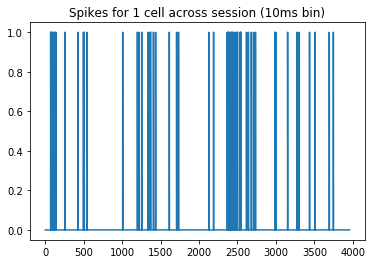

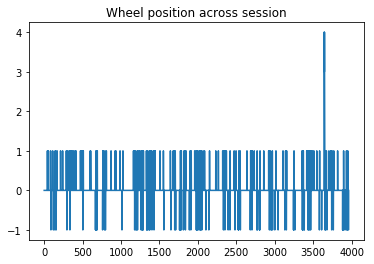

In [8]:
# Perform some quick visualisation on the spike and behaviour data

plt.figure(0)
cell_num = 42
plt.plot(midbrain_concat_left_spike_times[cell_num])
plt.title('Spikes for 1 cell across session (10ms bin)')
plt.show

plt.figure(1)
plt.plot(left_concat_wheel_position)
plt.title('Wheel position across session')
plt.show



/Users/xinweichia/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/xinweichia/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/xinweichia/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xinweichia/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(*args, **kw)>

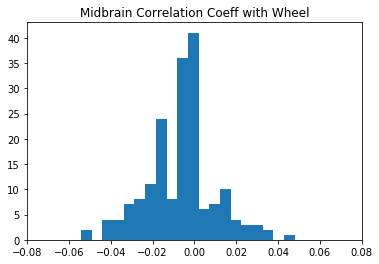

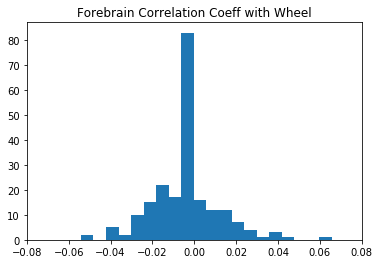

In [6]:
# Perform regression analysis

corr_coeff = np.array([])
for cell_num in np.arange(len(midbrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(midbrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(0)
plt.hist(corr_coeff,bins = 20)
plt.title('Midbrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

corr_coeff = np.array([])
for cell_num in np.arange(len(forebrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(forebrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(1)
plt.hist(corr_coeff,bins = 20)
plt.title('Forebrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

corr_coeff = np.array([])
for cell_num in np.arange(len(forebrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(forebrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(1)
plt.hist(corr_coeff,bins = 20)
plt.title('Forebrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show



In [30]:
print(corr_coeff)

(193,)
